# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [1]:
import logging
import Car
import Canvas
import RobotCarSimulator

In [2]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)

Model hyperparameters

In [3]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MEMORY_SIZE = 100_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [4]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors and the time exceeded (duration)

In [5]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 3 # we have three sensors

print(next_state, done, reward, duration) 

[ 30.         146.91333487 900.        ] False 25.31632308051881 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [7]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-22 22:58:39.928945: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 22:58:39.929228: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [8]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [9]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [10]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [11]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [12]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [13]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [14]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [15]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [16]:
import time
import pprint
import sys
start = time.time()

num_episodes = 2000
max_num_timesteps = 500

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 9 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11,13,15,17,19,21)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            print("\nBreaking episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            break
        if (t==(max_num_timesteps-1)):
            print("\nAborting episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        with open('train_episode_{}_seed_{}.txt'.format(i,seed), 'w') as f:
            f.write("actions:\n")
            f.write(pprint.pformat(sim._actionLog))
            f.write("\n\npositions:\n")
            f.write(pprint.pformat(sim._carPositions))
            f.write("\n\norientations:\n")
            f.write(pprint.pformat(sim._carOrientations))

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 40000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Breaking episode  0  with seed  2  after  99  steps with reward  -14326.0
Episode 1 | Total point average of the last 100 episodes: -14326.00
Breaking episode  1  with seed  5  after  121  steps with reward  -29871.37312436144
Episode 2 | Total point average of the last 100 episodes: -22098.69
Breaking episode  2  with seed  9  after  51  steps with reward  -23653.91593986831
Episode 3 | Total point average of the last 100 episodes: -22617.10
Breaking episode  3  with seed  11  after  127  steps with r

Episode 50 | Total point average of the last 100 episodes: -23414.46
Breaking episode  50  with seed  15  after  51  steps with reward  -8030.0
Episode 51 | Total point average of the last 100 episodes: -23112.81
Breaking episode  51  with seed  17  after  96  steps with reward  -29334.724407639842
Episode 52 | Total point average of the last 100 episodes: -23232.46
Breaking episode  52  with seed  19  after  48  steps with reward  -18837.153098170296
Episode 53 | Total point average of the last 100 episodes: -23149.53
Breaking episode  53  with seed  21  after  125  steps with reward  -18300.18846560715
Episode 54 | Total point average of the last 100 episodes: -23059.73
Breaking episode  54  with seed  2  after  80  steps with reward  -28428.904388404044
Episode 55 | Total point average of the last 100 episodes: -23157.35
Breaking episode  55  with seed  5  after  97  steps with reward  -14908.09696190225
Episode 56 | Total point average of the last 100 episodes: -23010.04
Breaking e

Episode 103 | Total point average of the last 100 episodes: -23132.32
Breaking episode  103  with seed  13  after  129  steps with reward  -20104.14668212277
Episode 104 | Total point average of the last 100 episodes: -23004.62
Breaking episode  104  with seed  15  after  27  steps with reward  -3580.0
Episode 105 | Total point average of the last 100 episodes: -22759.99
Breaking episode  105  with seed  17  after  88  steps with reward  -20530.209787256303
Episode 106 | Total point average of the last 100 episodes: -22593.79
Breaking episode  106  with seed  19  after  26  steps with reward  -18218.641687031653
Episode 107 | Total point average of the last 100 episodes: -22757.34
Breaking episode  107  with seed  21  after  71  steps with reward  -29315.68809755158
Episode 108 | Total point average of the last 100 episodes: -22709.54
Breaking episode  108  with seed  2  after  46  steps with reward  -24960.991071501885
Episode 109 | Total point average of the last 100 episodes: -22842

Episode 155 | Total point average of the last 100 episodes: -15666.40
Breaking episode  155  with seed  9  after  53  steps with reward  -2388.095473936824
Episode 156 | Total point average of the last 100 episodes: -15541.20
Breaking episode  156  with seed  11  after  367  steps with reward  -18853.740986145785
Episode 157 | Total point average of the last 100 episodes: -15496.53
Aborting episode  157  with seed  13  after  499  steps with reward  -10775.4524877417
Episode 158 | Total point average of the last 100 episodes: -15434.58
Breaking episode  158  with seed  15  after  242  steps with reward  31750.340982192618
Episode 159 | Total point average of the last 100 episodes: -14802.44
Breaking episode  159  with seed  17  after  163  steps with reward  3500.3034047483116
Episode 160 | Total point average of the last 100 episodes: -14449.84
Breaking episode  160  with seed  19  after  463  steps with reward  9777.012122839224
Episode 161 | Total point average of the last 100 episo

Episode 207 | Total point average of the last 100 episodes: -1518.69
Aborting episode  207  with seed  2  after  499  steps with reward  -10490.620994201974
Episode 208 | Total point average of the last 100 episodes: -1330.44
Aborting episode  208  with seed  5  after  499  steps with reward  9477.712148865401
Episode 209 | Total point average of the last 100 episodes: -986.05
Breaking episode  209  with seed  9  after  52  steps with reward  -792.2378121146261
Episode 210 | Total point average of the last 100 episodes: -761.28
Aborting episode  210  with seed  11  after  499  steps with reward  -15216.060886847677
Episode 211 | Total point average of the last 100 episodes: -661.08
Breaking episode  211  with seed  13  after  273  steps with reward  -8055.193154394952
Episode 212 | Total point average of the last 100 episodes: -516.03
Aborting episode  212  with seed  15  after  499  steps with reward  -5614.921520275895
Episode 213 | Total point average of the last 100 episodes: -311.

Episode 260 | Total point average of the last 100 episodes: 4954.14
Breaking episode  260  with seed  21  after  415  steps with reward  29398.049431173014
Episode 261 | Total point average of the last 100 episodes: 5150.35
Breaking episode  261  with seed  2  after  414  steps with reward  18518.405112232616
Episode 262 | Total point average of the last 100 episodes: 5447.34
Aborting episode  262  with seed  5  after  499  steps with reward  10852.736080903453
Episode 263 | Total point average of the last 100 episodes: 5331.75
Breaking episode  263  with seed  9  after  52  steps with reward  699.2707821701622
Episode 264 | Total point average of the last 100 episodes: 5042.54
Aborting episode  264  with seed  11  after  499  steps with reward  15568.574791982654
Episode 265 | Total point average of the last 100 episodes: 5191.49
Breaking episode  265  with seed  13  after  100  steps with reward  -4543.518767167278
Episode 266 | Total point average of the last 100 episodes: 5334.99
B

Episode 313 | Total point average of the last 100 episodes: 9958.62
Aborting episode  313  with seed  19  after  499  steps with reward  12709.331943092127
Episode 314 | Total point average of the last 100 episodes: 10067.57
Aborting episode  314  with seed  21  after  499  steps with reward  21343.80325293097
Episode 315 | Total point average of the last 100 episodes: 10251.92
Breaking episode  315  with seed  2  after  219  steps with reward  30076.983141891942
Episode 316 | Total point average of the last 100 episodes: 10601.51
Aborting episode  316  with seed  5  after  499  steps with reward  15777.225723155578
Episode 317 | Total point average of the last 100 episodes: 10501.31
Aborting episode  317  with seed  9  after  499  steps with reward  -17714.92739906917
Episode 318 | Total point average of the last 100 episodes: 10571.28
Breaking episode  318  with seed  11  after  420  steps with reward  -8613.337180336302
Episode 319 | Total point average of the last 100 episodes: 104

Episode 366 | Total point average of the last 100 episodes: 13675.13
Breaking episode  366  with seed  17  after  460  steps with reward  6748.4373961119245
Episode 367 | Total point average of the last 100 episodes: 13545.96
Aborting episode  367  with seed  19  after  499  steps with reward  8991.372736518564
Episode 368 | Total point average of the last 100 episodes: 13576.12
Aborting episode  368  with seed  21  after  499  steps with reward  15452.450823515575
Episode 369 | Total point average of the last 100 episodes: 13729.76
Aborting episode  369  with seed  2  after  499  steps with reward  11794.917245725786
Episode 370 | Total point average of the last 100 episodes: 13531.46
Aborting episode  370  with seed  5  after  499  steps with reward  14720.694348439587
Episode 371 | Total point average of the last 100 episodes: 13380.12
Aborting episode  371  with seed  9  after  499  steps with reward  7137.613744230163
Episode 372 | Total point average of the last 100 episodes: 133

Episode 419 | Total point average of the last 100 episodes: 12388.83
Breaking episode  419  with seed  15  after  45  steps with reward  619.4096801123366
Episode 420 | Total point average of the last 100 episodes: 12217.50
Aborting episode  420  with seed  17  after  499  steps with reward  5409.585250948641
Episode 421 | Total point average of the last 100 episodes: 12154.12
Breaking episode  421  with seed  19  after  206  steps with reward  1593.196601295561
Episode 422 | Total point average of the last 100 episodes: 12081.56
Breaking episode  422  with seed  21  after  379  steps with reward  32868.049207824864
Episode 423 | Total point average of the last 100 episodes: 12291.00
Breaking episode  423  with seed  2  after  67  steps with reward  -14245.637858024784
Episode 424 | Total point average of the last 100 episodes: 12050.99
Breaking episode  424  with seed  5  after  77  steps with reward  556.7297387030612
Episode 425 | Total point average of the last 100 episodes: 11742.

Episode 472 | Total point average of the last 100 episodes: 10858.17
Breaking episode  472  with seed  13  after  437  steps with reward  33360.08792550472
Episode 473 | Total point average of the last 100 episodes: 11029.21
Breaking episode  473  with seed  15  after  434  steps with reward  33046.546624547525
Episode 474 | Total point average of the last 100 episodes: 11059.07
Aborting episode  474  with seed  17  after  499  steps with reward  5526.347275239133
Episode 475 | Total point average of the last 100 episodes: 10926.42
Aborting episode  475  with seed  19  after  499  steps with reward  9669.497279157782
Episode 476 | Total point average of the last 100 episodes: 10967.04
Breaking episode  476  with seed  21  after  33  steps with reward  -14742.0
Episode 477 | Total point average of the last 100 episodes: 10763.27
Breaking episode  477  with seed  2  after  117  steps with reward  1749.0729640701297
Episode 478 | Total point average of the last 100 episodes: 10657.89
Abor

Episode 525 | Total point average of the last 100 episodes: 10920.52
Breaking episode  525  with seed  11  after  298  steps with reward  34929.59667651484
Episode 526 | Total point average of the last 100 episodes: 11134.67
Aborting episode  526  with seed  13  after  499  steps with reward  12607.295620834817
Episode 527 | Total point average of the last 100 episodes: 11201.10
Aborting episode  527  with seed  15  after  499  steps with reward  8907.088702523524
Episode 528 | Total point average of the last 100 episodes: 10956.04
Aborting episode  528  with seed  17  after  499  steps with reward  7304.377277503744
Episode 529 | Total point average of the last 100 episodes: 11037.81
Aborting episode  529  with seed  19  after  499  steps with reward  7523.483085638046
Episode 530 | Total point average of the last 100 episodes: 11044.87
Breaking episode  530  with seed  21  after  363  steps with reward  3834.4324630668675
Episode 531 | Total point average of the last 100 episodes: 10

Episode 578 | Total point average of the last 100 episodes: 9270.34
Aborting episode  578  with seed  9  after  499  steps with reward  12971.048348894987
Episode 579 | Total point average of the last 100 episodes: 9306.88
Aborting episode  579  with seed  11  after  499  steps with reward  18605.092013290476
Episode 580 | Total point average of the last 100 episodes: 9376.29
Aborting episode  580  with seed  13  after  499  steps with reward  10908.303325249712
Episode 581 | Total point average of the last 100 episodes: 9388.24
Breaking episode  581  with seed  15  after  332  steps with reward  31595.231293875717
Episode 582 | Total point average of the last 100 episodes: 9608.15
Aborting episode  582  with seed  17  after  499  steps with reward  6726.358131862096
Episode 583 | Total point average of the last 100 episodes: 9546.02
Aborting episode  583  with seed  19  after  499  steps with reward  9045.026170436526
Episode 584 | Total point average of the last 100 episodes: 9578.58

Episode 631 | Total point average of the last 100 episodes: 10221.63
Aborting episode  631  with seed  5  after  499  steps with reward  14123.848450088177
Episode 632 | Total point average of the last 100 episodes: 10045.67
Breaking episode  632  with seed  9  after  50  steps with reward  -14375.344180090831
Episode 633 | Total point average of the last 100 episodes: 10048.14
Aborting episode  633  with seed  11  after  499  steps with reward  9203.192205908606
Episode 634 | Total point average of the last 100 episodes: 10036.01
Breaking episode  634  with seed  13  after  497  steps with reward  30384.474357133135
Episode 635 | Total point average of the last 100 episodes: 10227.59
Aborting episode  635  with seed  15  after  499  steps with reward  17056.022502837204
Episode 636 | Total point average of the last 100 episodes: 10084.34
Aborting episode  636  with seed  17  after  499  steps with reward  6166.7348453866925
Episode 637 | Total point average of the last 100 episodes: 1

Episode 684 | Total point average of the last 100 episodes: 13715.00
Aborting episode  684  with seed  2  after  499  steps with reward  11902.957744193327
Episode 685 | Total point average of the last 100 episodes: 13707.13
Aborting episode  685  with seed  5  after  499  steps with reward  6856.0284673844435
Episode 686 | Total point average of the last 100 episodes: 13735.80
Aborting episode  686  with seed  9  after  499  steps with reward  18929.68257370776
Episode 687 | Total point average of the last 100 episodes: 13877.36
Aborting episode  687  with seed  11  after  499  steps with reward  19009.595400676946
Episode 688 | Total point average of the last 100 episodes: 14216.22
Aborting episode  688  with seed  13  after  499  steps with reward  11268.219900272672
Episode 689 | Total point average of the last 100 episodes: 14188.05
Aborting episode  689  with seed  15  after  499  steps with reward  15952.661409212811
Episode 690 | Total point average of the last 100 episodes: 14

Episode 737 | Total point average of the last 100 episodes: 16571.00
Aborting episode  737  with seed  21  after  499  steps with reward  17042.046630305733
Episode 738 | Total point average of the last 100 episodes: 16601.91
Breaking episode  738  with seed  2  after  216  steps with reward  30591.441860498417
Episode 739 | Total point average of the last 100 episodes: 16718.48
Breaking episode  739  with seed  5  after  224  steps with reward  38854.14722838363
Episode 740 | Total point average of the last 100 episodes: 16802.80
Breaking episode  740  with seed  9  after  194  steps with reward  2100.2147931493273
Episode 741 | Total point average of the last 100 episodes: 16657.54
Breaking episode  741  with seed  11  after  286  steps with reward  35801.04418497745
Episode 742 | Total point average of the last 100 episodes: 17163.91
Aborting episode  742  with seed  13  after  499  steps with reward  10636.22240525412
Episode 743 | Total point average of the last 100 episodes: 1689

Episode 790 | Total point average of the last 100 episodes: 18442.56
Aborting episode  790  with seed  19  after  499  steps with reward  8397.260777835927
Episode 791 | Total point average of the last 100 episodes: 18461.42
Breaking episode  791  with seed  21  after  395  steps with reward  18858.232479756844
Episode 792 | Total point average of the last 100 episodes: 18570.16
Breaking episode  792  with seed  2  after  275  steps with reward  31538.53665409577
Episode 793 | Total point average of the last 100 episodes: 18838.60
Breaking episode  793  with seed  5  after  294  steps with reward  38076.23656986916
Episode 794 | Total point average of the last 100 episodes: 19107.55
Aborting episode  794  with seed  9  after  499  steps with reward  23613.85477836707
Episode 795 | Total point average of the last 100 episodes: 18961.18
Aborting episode  795  with seed  11  after  499  steps with reward  10188.810392707428
Episode 796 | Total point average of the last 100 episodes: 19042

Episode 843 | Total point average of the last 100 episodes: 21087.63
Breaking episode  843  with seed  17  after  100  steps with reward  32597.604762167306
Episode 844 | Total point average of the last 100 episodes: 21091.94
Breaking episode  844  with seed  19  after  467  steps with reward  33595.173403867244
Episode 845 | Total point average of the last 100 episodes: 21360.49
Breaking episode  845  with seed  21  after  347  steps with reward  32377.292195473103
Episode 846 | Total point average of the last 100 episodes: 21368.98
Breaking episode  846  with seed  2  after  338  steps with reward  30679.23371784127
Episode 847 | Total point average of the last 100 episodes: 21485.07
Aborting episode  847  with seed  5  after  499  steps with reward  24415.36064035471
Episode 848 | Total point average of the last 100 episodes: 21419.85
Breaking episode  848  with seed  9  after  190  steps with reward  38565.16320390414
Episode 849 | Total point average of the last 100 episodes: 2143

Episode 896 | Total point average of the last 100 episodes: 21420.71
Breaking episode  896  with seed  15  after  386  steps with reward  32390.260010466605
Episode 897 | Total point average of the last 100 episodes: 21434.97
Breaking episode  897  with seed  17  after  463  steps with reward  6500.196529726799
Episode 898 | Total point average of the last 100 episodes: 21174.65
Breaking episode  898  with seed  19  after  215  steps with reward  -14008.779411628413
Episode 899 | Total point average of the last 100 episodes: 20679.76
Aborting episode  899  with seed  21  after  499  steps with reward  18950.054437600444
Episode 900 | Total point average of the last 100 episodes: 20530.75

Breaking episode  900  with seed  2  after  339  steps with reward  31226.964727194896
Episode 901 | Total point average of the last 100 episodes: 20642.58
Breaking episode  901  with seed  5  after  190  steps with reward  38519.96693898961
Episode 902 | Total point average of the last 100 episodes: 

Episode 949 | Total point average of the last 100 episodes: 21547.95
Breaking episode  949  with seed  13  after  107  steps with reward  29331.005467876683
Episode 950 | Total point average of the last 100 episodes: 21741.22
Breaking episode  950  with seed  15  after  3  steps with reward  -14970.0
Episode 951 | Total point average of the last 100 episodes: 21295.91
Breaking episode  951  with seed  17  after  242  steps with reward  33316.95283156358
Episode 952 | Total point average of the last 100 episodes: 21778.78
Breaking episode  952  with seed  19  after  135  steps with reward  31353.692424634064
Episode 953 | Total point average of the last 100 episodes: 21754.01
Breaking episode  953  with seed  21  after  85  steps with reward  32471.20011812331
Episode 954 | Total point average of the last 100 episodes: 21741.71
Breaking episode  954  with seed  2  after  414  steps with reward  30717.436109232025
Episode 955 | Total point average of the last 100 episodes: 21730.72
Break

Episode 1002 | Total point average of the last 100 episodes: 25691.18
Aborting episode  1002  with seed  11  after  499  steps with reward  9542.367424888595
Episode 1003 | Total point average of the last 100 episodes: 25404.59
Breaking episode  1003  with seed  13  after  53  steps with reward  29199.20955570491
Episode 1004 | Total point average of the last 100 episodes: 25591.47
Breaking episode  1004  with seed  15  after  182  steps with reward  32836.54946500005
Episode 1005 | Total point average of the last 100 episodes: 25620.00
Breaking episode  1005  with seed  17  after  249  steps with reward  6500.196529726799
Episode 1006 | Total point average of the last 100 episodes: 25358.69
Breaking episode  1006  with seed  19  after  93  steps with reward  31470.923715910867
Episode 1007 | Total point average of the last 100 episodes: 25608.40
Breaking episode  1007  with seed  21  after  185  steps with reward  18388.541057445465
Episode 1008 | Total point average of the last 100 e

Episode 1054 | Total point average of the last 100 episodes: 26502.42
Breaking episode  1054  with seed  5  after  158  steps with reward  38936.40964182306
Episode 1055 | Total point average of the last 100 episodes: 26584.61
Breaking episode  1055  with seed  9  after  434  steps with reward  38671.52934083583
Episode 1056 | Total point average of the last 100 episodes: 26584.81
Aborting episode  1056  with seed  11  after  499  steps with reward  9542.367424888595
Episode 1057 | Total point average of the last 100 episodes: 26292.62
Breaking episode  1057  with seed  13  after  61  steps with reward  29472.384005045667
Episode 1058 | Total point average of the last 100 episodes: 26492.07
Breaking episode  1058  with seed  15  after  186  steps with reward  32664.44750791147
Episode 1059 | Total point average of the last 100 episodes: 26520.25
Breaking episode  1059  with seed  17  after  133  steps with reward  5691.558468156407
Episode 1060 | Total point average of the last 100 epi

Episode 1106 | Total point average of the last 100 episodes: 25982.15
Breaking episode  1106  with seed  21  after  334  steps with reward  33918.482793428775
Episode 1107 | Total point average of the last 100 episodes: 26006.63
Breaking episode  1107  with seed  2  after  224  steps with reward  30459.49631838477
Episode 1108 | Total point average of the last 100 episodes: 26127.34
Aborting episode  1108  with seed  5  after  499  steps with reward  14131.808787322776
Episode 1109 | Total point average of the last 100 episodes: 25962.46
Breaking episode  1109  with seed  9  after  434  steps with reward  38356.29669800193
Episode 1110 | Total point average of the last 100 episodes: 26198.76
Aborting episode  1110  with seed  11  after  499  steps with reward  9542.367424888595
Episode 1111 | Total point average of the last 100 episodes: 25909.35
Breaking episode  1111  with seed  13  after  69  steps with reward  29778.462296915444
Episode 1112 | Total point average of the last 100 ep

Episode 1158 | Total point average of the last 100 episodes: 25151.28
Aborting episode  1158  with seed  17  after  499  steps with reward  5644.8848544314915
Episode 1159 | Total point average of the last 100 episodes: 24881.08
Breaking episode  1159  with seed  19  after  143  steps with reward  32427.32186637036
Episode 1160 | Total point average of the last 100 episodes: 25148.44
Breaking episode  1160  with seed  21  after  195  steps with reward  31612.830901678164
Episode 1161 | Total point average of the last 100 episodes: 25140.47
Breaking episode  1161  with seed  2  after  76  steps with reward  30147.200844333667
Episode 1162 | Total point average of the last 100 episodes: 25245.25
Breaking episode  1162  with seed  5  after  154  steps with reward  38511.09412568678
Episode 1163 | Total point average of the last 100 episodes: 25328.34
Breaking episode  1163  with seed  9  after  434  steps with reward  38064.9084165848
Episode 1164 | Total point average of the last 100 epi

Episode 1210 | Total point average of the last 100 episodes: 24758.50
Breaking episode  1210  with seed  13  after  275  steps with reward  30901.250352533185
Episode 1211 | Total point average of the last 100 episodes: 24972.09
Breaking episode  1211  with seed  15  after  280  steps with reward  32571.78185098406
Episode 1212 | Total point average of the last 100 episodes: 25000.02
Aborting episode  1212  with seed  17  after  499  steps with reward  6019.542438998448
Episode 1213 | Total point average of the last 100 episodes: 24735.95
Breaking episode  1213  with seed  19  after  431  steps with reward  33966.64195874684
Episode 1214 | Total point average of the last 100 episodes: 25005.29
Aborting episode  1214  with seed  21  after  499  steps with reward  19933.700226769855
Episode 1215 | Total point average of the last 100 episodes: 24882.24
Breaking episode  1215  with seed  2  after  360  steps with reward  30993.173887272133
Episode 1216 | Total point average of the last 100

Episode 1262 | Total point average of the last 100 episodes: 25669.85
Breaking episode  1262  with seed  9  after  172  steps with reward  38128.95281673428
Episode 1263 | Total point average of the last 100 episodes: 25666.03
Breaking episode  1263  with seed  11  after  398  steps with reward  34143.07665992694
Episode 1264 | Total point average of the last 100 episodes: 25626.81
Breaking episode  1264  with seed  13  after  61  steps with reward  30868.634736689986
Episode 1265 | Total point average of the last 100 episodes: 25590.43
Breaking episode  1265  with seed  15  after  3  steps with reward  -14970.0
Episode 1266 | Total point average of the last 100 episodes: 25140.75
Breaking episode  1266  with seed  17  after  219  steps with reward  33914.752484345954
Episode 1267 | Total point average of the last 100 episodes: 25155.86
Breaking episode  1267  with seed  19  after  96  steps with reward  1704.092391728107
Episode 1268 | Total point average of the last 100 episodes: 251

Episode 1314 | Total point average of the last 100 episodes: 24819.82
Breaking episode  1314  with seed  2  after  84  steps with reward  30389.37005945098
Episode 1315 | Total point average of the last 100 episodes: 24924.37
Breaking episode  1315  with seed  5  after  180  steps with reward  37190.16134224011
Episode 1316 | Total point average of the last 100 episodes: 24986.34
Breaking episode  1316  with seed  9  after  120  steps with reward  38647.87929666581
Episode 1317 | Total point average of the last 100 episodes: 24978.81
Aborting episode  1317  with seed  11  after  499  steps with reward  9917.018466160855
Episode 1318 | Total point average of the last 100 episodes: 24692.55
Breaking episode  1318  with seed  13  after  183  steps with reward  31605.574436839575
Episode 1319 | Total point average of the last 100 episodes: 24662.03
Breaking episode  1319  with seed  15  after  3  steps with reward  -14970.0
Episode 1320 | Total point average of the last 100 episodes: 24213

Episode 1366 | Total point average of the last 100 episodes: 23413.66
Aborting episode  1366  with seed  19  after  499  steps with reward  1123.8467868251637
Episode 1367 | Total point average of the last 100 episodes: 23085.75
Breaking episode  1367  with seed  21  after  432  steps with reward  19847.636163949228
Episode 1368 | Total point average of the last 100 episodes: 23267.19
Breaking episode  1368  with seed  2  after  96  steps with reward  30965.981082185237
Episode 1369 | Total point average of the last 100 episodes: 23256.40
Breaking episode  1369  with seed  5  after  394  steps with reward  16014.22672348102
Episode 1370 | Total point average of the last 100 episodes: 23106.01
Breaking episode  1370  with seed  9  after  456  steps with reward  39025.80875508809
Episode 1371 | Total point average of the last 100 episodes: 23107.77
Breaking episode  1371  with seed  11  after  190  steps with reward  34601.42919027862
Episode 1372 | Total point average of the last 100 ep

Episode 1418 | Total point average of the last 100 episodes: 23947.07
Breaking episode  1418  with seed  15  after  114  steps with reward  32451.117500334072
Episode 1419 | Total point average of the last 100 episodes: 23955.52
Breaking episode  1419  with seed  17  after  432  steps with reward  6436.670823288269
Episode 1420 | Total point average of the last 100 episodes: 24169.59
Aborting episode  1420  with seed  19  after  499  steps with reward  1476.2279693428027
Episode 1421 | Total point average of the last 100 episodes: 23853.86
Breaking episode  1421  with seed  21  after  301  steps with reward  19586.0919154565
Episode 1422 | Total point average of the last 100 episodes: 24189.81
Breaking episode  1422  with seed  2  after  180  steps with reward  30099.373406210147
Episode 1423 | Total point average of the last 100 episodes: 24170.50
Breaking episode  1423  with seed  5  after  120  steps with reward  39189.51227560772
Episode 1424 | Total point average of the last 100 e

Episode 1470 | Total point average of the last 100 episodes: 25077.69
Breaking episode  1470  with seed  11  after  430  steps with reward  35181.19481837374
Episode 1471 | Total point average of the last 100 episodes: 25039.25
Breaking episode  1471  with seed  13  after  405  steps with reward  29476.34482751845
Episode 1472 | Total point average of the last 100 episodes: 24988.00
Breaking episode  1472  with seed  15  after  76  steps with reward  32371.05523852648
Episode 1473 | Total point average of the last 100 episodes: 25008.20
Breaking episode  1473  with seed  17  after  233  steps with reward  7276.543063857868
Episode 1474 | Total point average of the last 100 episodes: 24914.89
Breaking episode  1474  with seed  19  after  459  steps with reward  32915.97452367049
Episode 1475 | Total point average of the last 100 episodes: 25185.81
Aborting episode  1475  with seed  21  after  499  steps with reward  19186.987798305858
Episode 1476 | Total point average of the last 100 e

Episode 1522 | Total point average of the last 100 episodes: 26179.75
Aborting episode  1522  with seed  5  after  499  steps with reward  18010.73508778595
Episode 1523 | Total point average of the last 100 episodes: 26058.86
Breaking episode  1523  with seed  9  after  83  steps with reward  1694.023697247429
Episode 1524 | Total point average of the last 100 episodes: 25683.91
Aborting episode  1524  with seed  11  after  499  steps with reward  9588.974459098816
Episode 1525 | Total point average of the last 100 episodes: 25395.04
Breaking episode  1525  with seed  13  after  75  steps with reward  30916.49447141561
Episode 1526 | Total point average of the last 100 episodes: 25370.82
Breaking episode  1526  with seed  15  after  158  steps with reward  32196.39037526906
Episode 1527 | Total point average of the last 100 episodes: 25387.41
Breaking episode  1527  with seed  17  after  165  steps with reward  6554.202560116786
Episode 1528 | Total point average of the last 100 episo

Episode 1574 | Total point average of the last 100 episodes: 25992.47
Breaking episode  1574  with seed  21  after  229  steps with reward  19232.79649443445
Episode 1575 | Total point average of the last 100 episodes: 25855.64
Breaking episode  1575  with seed  2  after  248  steps with reward  30586.802734521945
Episode 1576 | Total point average of the last 100 episodes: 25969.64
Breaking episode  1576  with seed  5  after  316  steps with reward  38759.09699714284
Episode 1577 | Total point average of the last 100 episodes: 26051.21
Breaking episode  1577  with seed  9  after  146  steps with reward  39605.64044374368
Episode 1578 | Total point average of the last 100 episodes: 26062.68
Breaking episode  1578  with seed  11  after  130  steps with reward  34896.23351773602
Episode 1579 | Total point average of the last 100 episodes: 26016.22
Breaking episode  1579  with seed  13  after  121  steps with reward  30827.775058071697
Episode 1580 | Total point average of the last 100 ep

Episode 1626 | Total point average of the last 100 episodes: 26957.91
Aborting episode  1626  with seed  17  after  499  steps with reward  6500.196529726799
Episode 1627 | Total point average of the last 100 episodes: 26700.95
Aborting episode  1627  with seed  19  after  499  steps with reward  1149.8989700296286
Episode 1628 | Total point average of the last 100 episodes: 26646.90
Breaking episode  1628  with seed  21  after  309  steps with reward  19843.56506872311
Episode 1629 | Total point average of the last 100 episodes: 26830.48
Breaking episode  1629  with seed  2  after  92  steps with reward  30460.48070734795
Episode 1630 | Total point average of the last 100 episodes: 26951.15
Breaking episode  1630  with seed  5  after  158  steps with reward  39939.79221436094
Episode 1631 | Total point average of the last 100 episodes: 27046.22
Aborting episode  1631  with seed  9  after  499  steps with reward  23794.062173003873
Episode 1632 | Total point average of the last 100 epi

Episode 1678 | Total point average of the last 100 episodes: 25270.17
Breaking episode  1678  with seed  13  after  83  steps with reward  30827.745931126025
Episode 1679 | Total point average of the last 100 episodes: 25229.48
Breaking episode  1679  with seed  15  after  76  steps with reward  32371.05523852648
Episode 1680 | Total point average of the last 100 episodes: 25244.92
Aborting episode  1680  with seed  17  after  499  steps with reward  6700.196529726799
Episode 1681 | Total point average of the last 100 episodes: 24988.94
Breaking episode  1681  with seed  19  after  373  steps with reward  32754.221480153738
Episode 1682 | Total point average of the last 100 episodes: 25241.63
Breaking episode  1682  with seed  21  after  183  steps with reward  19118.940984644953
Episode 1683 | Total point average of the last 100 episodes: 25105.02
Breaking episode  1683  with seed  2  after  68  steps with reward  30091.28762881516
Episode 1684 | Total point average of the last 100 ep

Episode 1730 | Total point average of the last 100 episodes: 23871.29
Breaking episode  1730  with seed  9  after  150  steps with reward  38231.847664743516
Episode 1731 | Total point average of the last 100 episodes: 23854.21
Breaking episode  1731  with seed  11  after  140  steps with reward  33964.56466517075
Episode 1732 | Total point average of the last 100 episodes: 23955.92
Breaking episode  1732  with seed  13  after  59  steps with reward  30523.704716149026
Episode 1733 | Total point average of the last 100 episodes: 24164.32
Breaking episode  1733  with seed  15  after  94  steps with reward  32152.66898341654
Episode 1734 | Total point average of the last 100 episodes: 24180.48
Breaking episode  1734  with seed  17  after  125  steps with reward  6516.3554850020855
Episode 1735 | Total point average of the last 100 episodes: 23921.93
Breaking episode  1735  with seed  19  after  314  steps with reward  34335.1814358712
Episode 1736 | Total point average of the last 100 ep

Episode 1782 | Total point average of the last 100 episodes: 23480.69
Breaking episode  1782  with seed  2  after  81  steps with reward  29957.921113530236
Episode 1783 | Total point average of the last 100 episodes: 23589.08
Breaking episode  1783  with seed  5  after  106  steps with reward  38694.83389573201
Episode 1784 | Total point average of the last 100 episodes: 23675.12
Breaking episode  1784  with seed  9  after  180  steps with reward  38661.05199785281
Episode 1785 | Total point average of the last 100 episodes: 23896.14
Breaking episode  1785  with seed  11  after  472  steps with reward  32952.74399890855
Episode 1786 | Total point average of the last 100 episodes: 23832.20
Breaking episode  1786  with seed  13  after  97  steps with reward  29423.69903819439
Episode 1787 | Total point average of the last 100 episodes: 24029.93
Breaking episode  1787  with seed  15  after  3  steps with reward  -14970.0
Episode 1788 | Total point average of the last 100 episodes: 23580.

Episode 1834 | Total point average of the last 100 episodes: 22871.42
Breaking episode  1834  with seed  19  after  434  steps with reward  34543.99854132607
Episode 1835 | Total point average of the last 100 episodes: 23151.70
Breaking episode  1835  with seed  21  after  300  steps with reward  18996.56647133916
Episode 1836 | Total point average of the last 100 episodes: 22998.32
Breaking episode  1836  with seed  2  after  104  steps with reward  30176.114846663964
Episode 1837 | Total point average of the last 100 episodes: 22981.55
Breaking episode  1837  with seed  5  after  120  steps with reward  39053.21001110073
Episode 1838 | Total point average of the last 100 episodes: 23357.17
Breaking episode  1838  with seed  9  after  469  steps with reward  17434.3565971654
Episode 1839 | Total point average of the last 100 episodes: 23278.99
Aborting episode  1839  with seed  11  after  499  steps with reward  9950.930581887182
Episode 1840 | Total point average of the last 100 epis

Episode 1886 | Total point average of the last 100 episodes: 24425.48
Breaking episode  1886  with seed  15  after  86  steps with reward  32377.27622917153
Episode 1887 | Total point average of the last 100 episodes: 24455.01
Aborting episode  1887  with seed  17  after  499  steps with reward  6500.196529726799
Episode 1888 | Total point average of the last 100 episodes: 24669.71
Aborting episode  1888  with seed  19  after  499  steps with reward  2499.256570723596
Episode 1889 | Total point average of the last 100 episodes: 24354.57
Breaking episode  1889  with seed  21  after  189  steps with reward  19632.01456044903
Episode 1890 | Total point average of the last 100 episodes: 24690.98
Breaking episode  1890  with seed  2  after  152  steps with reward  30482.43283331189
Episode 1891 | Total point average of the last 100 episodes: 24661.05
Breaking episode  1891  with seed  5  after  106  steps with reward  38694.83389573201
Episode 1892 | Total point average of the last 100 epis

Episode 1938 | Total point average of the last 100 episodes: 25546.65
Breaking episode  1938  with seed  11  after  220  steps with reward  34612.09936409636
Episode 1939 | Total point average of the last 100 episodes: 25718.43
Breaking episode  1939  with seed  13  after  61  steps with reward  30608.23599736826
Episode 1940 | Total point average of the last 100 episodes: 25925.00
Breaking episode  1940  with seed  15  after  170  steps with reward  32237.393104030594
Episode 1941 | Total point average of the last 100 episodes: 25947.82
Aborting episode  1941  with seed  17  after  499  steps with reward  6500.196529726799
Episode 1942 | Total point average of the last 100 episodes: 25689.85
Breaking episode  1942  with seed  19  after  404  steps with reward  34395.95649316636
Episode 1943 | Total point average of the last 100 episodes: 25968.81
Aborting episode  1943  with seed  21  after  499  steps with reward  20404.08010009404
Episode 1944 | Total point average of the last 100 e

Episode 1990 | Total point average of the last 100 episodes: 26819.79
Breaking episode  1990  with seed  5  after  316  steps with reward  39401.28282912582
Episode 1991 | Total point average of the last 100 episodes: 26908.98
Breaking episode  1991  with seed  9  after  112  steps with reward  38632.5045247861
Episode 1992 | Total point average of the last 100 episodes: 26908.35
Breaking episode  1992  with seed  11  after  108  steps with reward  34679.610684955114
Episode 1993 | Total point average of the last 100 episodes: 26874.00
Breaking episode  1993  with seed  13  after  61  steps with reward  30008.07375386534
Episode 1994 | Total point average of the last 100 episodes: 27072.31
Breaking episode  1994  with seed  15  after  92  steps with reward  32089.523479628402
Episode 1995 | Total point average of the last 100 episodes: 27094.63
Breaking episode  1995  with seed  17  after  490  steps with reward  7448.123170325042
Episode 1996 | Total point average of the last 100 epis

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

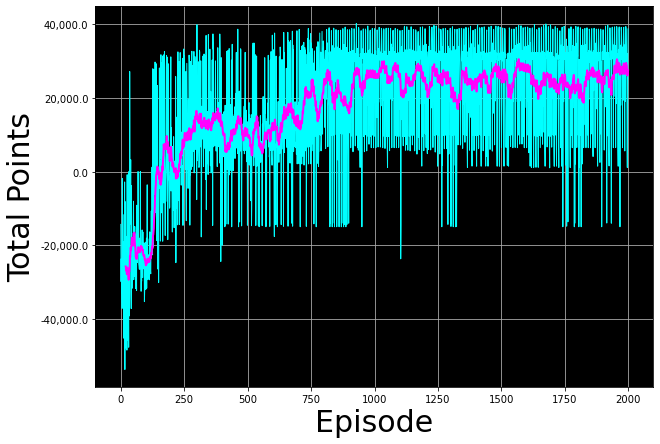

In [18]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [19]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [21]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)
seed=5


car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=seed)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True)

while not sim.isTerminated() and sim.getDuration() < 20.0:
    state_qn = np.expand_dims(np.array(sim.getLineTrackingSensorValues()), axis=0)
    q_values = model(state_qn)
    action = np.argmax(q_values.numpy()[0])
    actions[action]()
    
sim.saveImage('model_seed_{}.gif'.format(seed))
with open('model_seed_{}.txt'.format(seed), 'w') as f:
    f.write("actions:\n")
    f.write(pprint.pformat(sim._actionLog))
    f.write("\n\npositions:\n")
    f.write(pprint.pformat(sim._carPositions))
    f.write("\n\norientations:\n")
    f.write(pprint.pformat(sim._carOrientations))